<a href="https://colab.research.google.com/github/eriosta/neuro/blob/main/Hierarchical_Clustering_of_Spatial_Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q nilearn
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets
from nilearn.decomposition import DictLearning
from nilearn import plotting, image
from scipy.stats import pearsonr
from nilearn import datasets, image
from nilearn.decomposition import DictLearning
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 20.3 MB/s eta 0:00:00



Dataset created in /root/nilearn_data/adhd



 ...done. (1 seconds, 0 min)
Extracting data from /root/nilearn_data/adhd/fbef5baff0b388a8c913a08e1d84e059/adhd40_metadata.tgz..... done.


Downloaded 30367744 of 44414948 bytes (68.4%,    1.4s remaining) ...done. (5 seconds, 0 min)
Extracting data from /root/nilearn_data/adhd/e7ff5670bd594dcd9453e57b55d69dc9/adhd40_0010042.tgz..... done.
/usr/local/lib/python3.10/dist-packages/joblib/memory.py:353: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:739: FutureWarning: 'n_iter' is deprecated in version 1.1 and will be removed in version 1.3. Use 'max_iter' instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:739: FutureWa

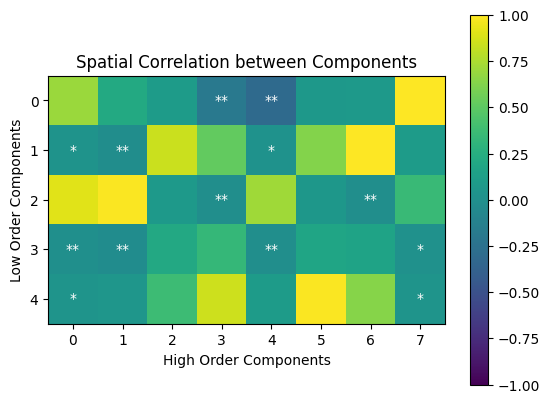

In [2]:
# Choose how many subjects to get (e.g., 1 subject)
n_subjects = 1

# Fetch the ADHD200 resting-state fMRI dataset
adhd_dataset = datasets.fetch_adhd(n_subjects=n_subjects)
func_filenames = adhd_dataset.func

# Decomposition into 5 components
dict_learn_5 = DictLearning(n_components=5, random_state=0, memory="nilearn_cache", memory_level=2)
components_img_5 = dict_learn_5.fit_transform(func_filenames)
# Decomposition into 8 components
dict_learn_8 = DictLearning(n_components=8, random_state=0, memory="nilearn_cache", memory_level=2)
components_img_8 = dict_learn_8.fit_transform(func_filenames)

# Initialize correlation matrix
correlation_matrix = np.zeros((5, 8))

for i in range(5):
    for j in range(8):
        # Extract data arrays
        data_5 = components_img_5[0][..., i]
        data_8 = components_img_8[0][..., j]

        # Compute the spatial correlation between the two components
        correlation = np.corrcoef(data_5.ravel(), data_8.ravel())[0, 1]

        correlation_matrix[i, j] = correlation

# Visualize the correlation matrix using a heatmap with annotations
plt.imshow(correlation_matrix, cmap='viridis', vmin=-1, vmax=1)

for i in range(5):
    for j in range(8):
        if correlation_matrix[i, j] < 0.001:
            plt.text(j, i, f'**', ha='center', va='center', color='white')
        elif correlation_matrix[i, j] < 0.05:
            plt.text(j, i, f'*', ha='center', va='center', color='white')
        else:
            plt.text(j, i, f'', ha='center', va='center', color='black')

plt.colorbar()
plt.xlabel("High Order Components")
plt.ylabel("Low Order Components")
plt.title("Spatial Correlation between Components")
plt.show()


Enter the number of low-order components: 5
Enter the number of high-order components: 10


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:739: FutureWarning: 'n_iter' is deprecated in version 1.1 and will be removed in version 1.3. Use 'max_iter' instead.
  warnings.warn(msg, FutureWarning)


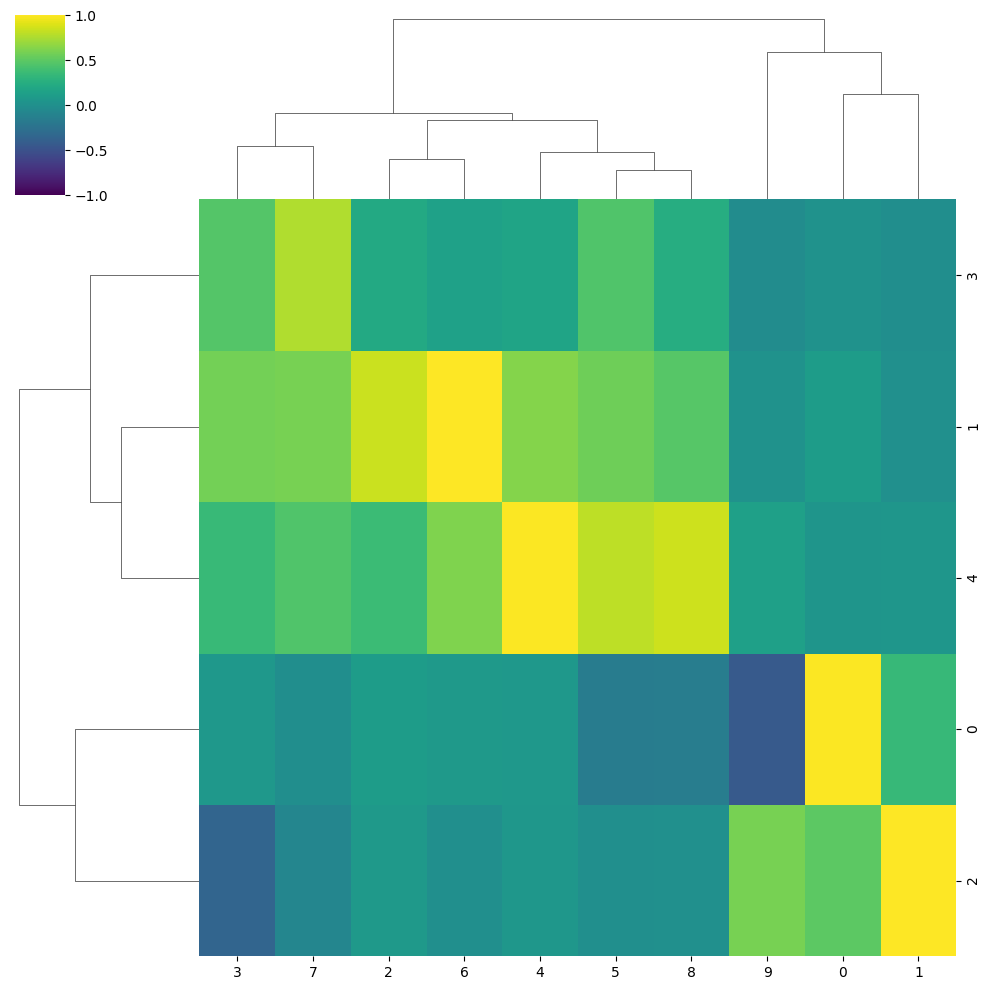

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets
from nilearn.decomposition import DictLearning
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import seaborn as sns
from scipy.stats import pearsonr

class ComponentCorrelationVisualizer:
    def __init__(self, n_low_order, n_high_order):
        self.n_low_order = n_low_order
        self.n_high_order = n_high_order

    def fetch_data(self):
        n_subjects = 1
        adhd_dataset = datasets.fetch_adhd(n_subjects=n_subjects)
        self.func_filenames = adhd_dataset.func

    def perform_decomposition(self):
        dict_learn_low = DictLearning(n_components=self.n_low_order, random_state=0, memory="nilearn_cache", memory_level=2)
        self.components_img_low = dict_learn_low.fit_transform(self.func_filenames)

        dict_learn_high = DictLearning(n_components=self.n_high_order, random_state=0, memory="nilearn_cache", memory_level=2)
        self.components_img_high = dict_learn_high.fit_transform(self.func_filenames)

    def compute_correlation_matrix(self):
        self.correlation_matrix = np.zeros((self.n_low_order, self.n_high_order))
        self.p_values = np.ones((self.n_low_order, self.n_high_order))
        for i in range(self.n_low_order):
            for j in range(self.n_high_order):
                data_low = self.components_img_low[0][..., i]
                data_high = self.components_img_high[0][..., j]
                correlation, p_value = pearsonr(data_low.ravel(), data_high.ravel())
                self.correlation_matrix[i, j] = correlation
                self.p_values[i, j] = p_value

    def plot_heatmap(self):
        # Plotting hierarchical clustering heatmap
        g = sns.clustermap(self.correlation_matrix, method='average', cmap='viridis', vmin=-1, vmax=1, annot=False, fmt=".2f")

        # # TO-DO: INSTEAD OF OVERLAY, DO NOT DISPLAY CELLS THAT ARE NOT P<0.05
        # # Overlay p-value symbols
        # for i in range(self.n_low_order):
        #     for j in range(self.n_high_order):
        #         if self.p_values[i, j] < 0.001:
        #             g.ax_heatmap.text(j+0.5, i+0.5, '**', ha='center', va='center', color='white')
        #         elif self.p_values[i, j] < 0.05:
        #             g.ax_heatmap.text(j+0.5, i+0.5, '*', ha='center', va='center', color='white')

    def visualize_component_correlation(self):
        self.fetch_data()
        self.perform_decomposition()
        self.compute_correlation_matrix()
        self.plot_heatmap()

if __name__ == "__main__":
    n_low_order = int(input("Enter the number of low-order components: "))
    n_high_order = int(input("Enter the number of high-order components: "))
    visualizer = ComponentCorrelationVisualizer(n_low_order, n_high_order)
    visualizer.visualize_component_correlation()
